In [23]:
import rasterio #Used for handling .tif files
from rasterio.plot import show #Used to plot a .tif file
import rioxarray as rio
import os
import numpy as np
import pandas as pd
from osgeo import gdal,ogr,osr

In [24]:
tif = r'/home/becode2/Lidar_project/3D-house-lidar-data/data/GeoTIFF//DHMVIIDSMRAS1m_k43.tif'

ds = rasterio.open(tif)
ds.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 6000,
 'height': 7000,
 'count': 1,
 'crs': CRS.from_epsg(31370),
 'transform': Affine(1.0, 0.0, 258000.0,
        0.0, -1.0, 158000.0)}

In [25]:
ds.bounds

BoundingBox(left=258000.0, bottom=151000.0, right=264000.0, top=158000.0)

In [26]:
raster=r'/home/becode2/Lidar_project/3D-house-lidar-data/data/GeoTIFF/DHMVIIDSMRAS1m_k43.tif'
ds=gdal.Open(raster)
ds.GetProjection()

'PROJCS["Belge 1972 / Belgian Lambert 72",GEOGCS["Belge 1972",DATUM["Reseau_National_Belge_1972",SPHEROID["International 1924",6378388,297,AUTHORITY["EPSG","7022"]],TOWGS84[-106.869,52.2978,-103.724,0.3366,-0.457,1.8422,-1.2747],AUTHORITY["EPSG","6313"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4313"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",90],PARAMETER["central_meridian",4.36748666666667],PARAMETER["standard_parallel_1",51.1666672333333],PARAMETER["standard_parallel_2",49.8333339],PARAMETER["false_easting",150000.013],PARAMETER["false_northing",5400088.438],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","31370"]]'

In [27]:
def GetExtent(ds):
    """ Return list of corner coordinates from a gdal Dataset """
    xmin, xpixel, _, ymax, _, ypixel = ds.GetGeoTransform()
    width, height = ds.RasterXSize, ds.RasterYSize
    xmax = xmin + width * xpixel
    ymin = ymax + height * ypixel

    return (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)

def ReprojectCoords(coords,src_srs,tgt_srs):
    """ Reproject a list of x,y coordinates. """
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

raster=r'/home/becode2/Lidar_project/3D-house-lidar-data/data/GeoTIFF/DHMVIIDSMRAS1m_k43.tif'
ds=gdal.Open(raster)

ext=GetExtent(ds)

src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(ds.GetProjection())
tgt_srs=osr.SpatialReference()
tgt_srs.ImportFromEPSG(4326)
#tgt_srs = src_srs.CloneGeogCS()

geo_ext=ReprojectCoords(ext, src_srs, tgt_srs)
geo_ext

#lingitud = y
#latitud = x
ext

((258000.0, 158000.0),
 (264000.0, 158000.0),
 (264000.0, 151000.0),
 (258000.0, 151000.0))

In [28]:
def ReReprojectCoords(coords,r_src_srs,r_tgt_srs):
    """ Reproject a list of x,y coordinates. """
    trans_coords=[]
    transform = osr.CoordinateTransformation( r_src_srs, r_tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

ext2 = ((50.72252633288402, 5.89834688250441), (50.72138393044125, 5.983298364804676), (50.65846970959621, 5.9811449881621295), (50.659610605121614, 5.8963066962772395))

r_tgt_srs=osr.SpatialReference()
r_tgt_srs.ImportFromWkt(ds.GetProjection())
r_src_srs=osr.SpatialReference()
r_src_srs.ImportFromEPSG(4326)

new_ext = ReReprojectCoords(ext2, r_src_srs, r_tgt_srs)
new_ext

[[257999.99977259382, 158000.00037245825],
 [263999.99977059785, 158000.00037340727],
 [263999.9997694918, 151000.00037578214],
 [257999.9997714907, 151000.00037483312]]

In [29]:
#get address as input
import geopy
from geopy.geocoders import Nominatim
nom = Nominatim(user_agent="Mon_Application")
user = input('Enter address')
address = nom.geocode(user)

Enter addressbrussels


In [30]:
address.raw['display_name']

'Ville de Bruxelles - Stad Brussel, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, België / Belgique / Belgien'

In [31]:
#get coordinates
lat = address.latitude
long = address.longitude
long

4.351697

In [32]:
#transform it them into lambert
coord = [lat, long]

tgt_srs=osr.SpatialReference()
tgt_srs.ImportFromEPSG(31370)
src_srs=osr.SpatialReference()
src_srs.ImportFromEPSG(4326)

trans_coords=[]

transform = osr.CoordinateTransformation(src_srs, tgt_srs)
x,y,z = transform.TransformPoint(lat,long)
trans_coords.append([x,y])
trans_coords[0][0]

148798.8867695195

In [33]:
#open all files and extract de bounds in lambert
count = 31
b_list = []

while count < 32 :
    tif = r'/home/becode2/Lidar_project/3D-house-lidar-data/data/GeoTIFF/DHMVIIDSMRAS1m_k' + str(count) + '.tif'
    possible_ds = rasterio.open(tif)
    b_list = list(possible_ds.bounds)
    if int(b_list[0]) <= int(trans_coords[0][0]) <= int(b_list[2]):
        ds = possible_ds
        break
    else :
        count +=1
b_list

[130000.0, 158000.0, 162000.0, 178000.0]

In [56]:
# Calculate pixels to Lambert
xmin = trans_coords[0][0] - 21
xmax = trans_coords[0][0] + 21
ymax = trans_coords[0][1] + 21
ymin = trans_coords[0][1] - 21

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa1d27d74e0> >
(148777.8867695195, 170704.78021211643, 148819.8867695195, 170662.78021211643)


Warning 1: TIFFReadDirectory:Bogus "StripByteCounts" field, ignoring and calculating from imagelength


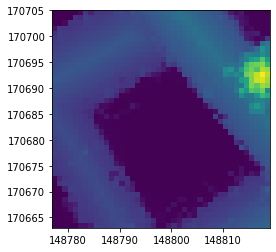

<AxesSubplot:>

In [57]:
raster= tif
ds2 = gdal.Open(raster)
print(ds2)
bbox = (xmin,ymax,xmax,ymin)
print(bbox)
ds2 = gdal.Translate('new.tif', ds2, projWin = bbox)
ds3 = rasterio.open('new.tif')
show(ds3)

In [58]:
array = ds3.read(1)

In [59]:
df = pd.DataFrame(data=array)
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,20.129999,20.150000,20.150000,20.150000,20.190001,22.830000,35.540001,29.639999,35.160000,35.320000,...,43.900002,39.430000,27.680000,23.420000,26.820000,20.840000,20.830000,20.830000,20.840000,20.830000
1,20.129999,20.100000,20.160000,20.170000,33.720001,32.099998,38.130001,35.840000,36.189999,36.849998,...,46.450001,43.660000,36.450001,28.930000,25.530001,23.040001,20.870001,20.860001,20.860001,20.870001
2,20.139999,20.139999,22.379999,34.650002,35.099998,35.610001,37.299999,37.669998,37.320000,37.959999,...,46.080002,44.680000,43.470001,39.580002,26.010000,23.969999,20.889999,20.900000,20.879999,20.879999
3,25.490000,36.160000,35.020000,35.369999,35.720001,36.529999,37.169998,37.930000,38.560001,39.230000,...,47.290001,45.820000,45.099998,41.660000,31.520000,22.230000,23.270000,20.910000,20.920000,20.920000
4,32.880001,37.639999,35.860001,36.419998,37.090000,37.840000,38.549999,39.080002,39.770000,40.509998,...,48.540001,46.990002,46.560001,44.169998,35.930000,27.660000,26.790001,28.190001,20.940001,20.930000
5,35.959999,38.070000,37.189999,37.660000,38.389999,39.180000,39.820000,40.470001,41.150002,41.939999,...,49.549999,48.250000,46.660000,45.250000,43.860001,28.469999,25.570000,21.299999,23.090000,35.139999
6,36.660000,37.439999,38.189999,39.000000,39.669998,40.400002,41.160000,41.750000,42.500000,43.250000,...,51.639999,49.259998,49.189999,46.400002,45.299999,43.630001,38.820000,27.639999,53.759998,59.430000
7,38.070000,38.779999,39.480000,40.189999,41.009998,41.810001,42.410000,43.119999,43.750000,44.650002,...,51.860001,50.540001,49.040001,47.529999,46.369999,44.650002,46.369999,54.009998,68.940002,60.590000
8,39.270000,40.029999,40.810001,41.570000,42.310001,43.040001,43.779999,44.340000,45.200001,45.759998,...,53.220001,51.619999,51.110001,48.730000,51.830002,61.820000,61.000000,58.799999,67.559998,60.790001
9,40.639999,41.270000,42.080002,42.790001,43.580002,44.380001,45.060001,45.820000,45.259998,44.490002,...,54.490002,52.889999,51.450001,49.919998,56.759998,61.619999,72.959999,75.959999,88.980003,72.029999


In [60]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure(data=[go.Surface(z=df.values)])
fig.update_layout(title='Pyiterator', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()